#Predownloaded Package

In [ ]:
#pre install library
#pip install matplotlib
#pip install -U scikit-learn
#pip install -U nltk
#!pip install imbalanced-learn
#!pip install flask-cors
#!pip install flask

# Load Dataset from Json File

In [ ]:
from types import NoneType
import json

# Load the dataset
with open('/content/chatbot_training_data.json', 'r') as file:
    dataset = json.load(file)

if dataset is not None:
  print("Dataset Loaded")


Dataset Loaded


# Extract Features and Labels from Dataset


In [ ]:
#Features is the input/independent variable for the machine learning used to predict.
#label is the output/dependent variable for the machine learning to predict
#each Feature(patterns) should has a Label(tag)

Features =[]
Labels = []
Unique_labels=set()


for data in dataset["intents"]:
  Unique_labels.add(data["tag"])
  patterns=(data["patterns"])
  for pattern in patterns:
    Features.append(pattern.strip())
    Labels.append(data["tag"])

print("Total Features:"+ str(len(Features)));
print("Total Labels:"+ str(len(Unique_labels)));

Total Features:20243
Total Labels:30


In [ ]:
#print example label and related features


for i, tag in enumerate(Unique_labels):
    if i == 3:
        break

    print("Label : "+ tag)
    print("Related Patterns:")
    pattern_count=0
    for j, label in enumerate(Labels):
        if label == tag:
            print("-", Features[j])
            pattern_count += 1
            if pattern_count == 3:
                break

    print()


Label : complaint
Related Patterns:
- ask an agent how i can make a consumer complaint for a service
- I want to submit a complaint, what do I have to do?
- I'm discontent with the service, how caj I submit a consumer complaint?

Label : goodbye
Related Patterns:
- Goodbye
- See you later
- Bye

Label : bot_challenging
Related Patterns:
- Are you even smart?
- Can you really understand me?
- What makes you different from other bots?



#Preproccesing Data

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#download the neccessary file
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

#data processing function
def data_processing(pattern) :
  #remove punctuation
  pattern = re.sub(r'[^\w\s\d]', '', pattern)

  #convert to lowercase
  pattern = pattern.lower()

  #tokenization (list)
  token=nltk.word_tokenize(pattern)

  #remove stop words
  for word in token:
    if word in stopwords.words('english'):
      token.remove(word)

  #lemmatization
  for i, word in enumerate(token):
    token[i] = lemmatizer.lemmatize(word)

  #join back the token words
  processed_pattern = ' '.join(token)

  #return the processed pattern
  return processed_pattern

#store processed_features
processed_features = []
for pattern in Features:
  processed_features.append(data_processing(pattern))

#print example processed_features
for i in range(10):
  print()
  print("Original Pattern: " + Features[i])
  print("Processed Pattern: " + processed_features[i])

#label no need preprocess
proccessed_labels = Labels

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



Original Pattern: Hello
Processed Pattern: hello

Original Pattern: Hi there!
Processed Pattern: hi

Original Pattern: Hey!
Processed Pattern: hey

Original Pattern: halo
Processed Pattern: halo

Original Pattern: whatsup, bro
Processed Pattern: whatsup bro

Original Pattern: goodays
Processed Pattern: goodays

Original Pattern: yo
Processed Pattern: yo

Original Pattern: yoyo
Processed Pattern: yoyo

Original Pattern: Good morning
Processed Pattern: good morning

Original Pattern: Good evening
Processed Pattern: good evening


#Data Balancing

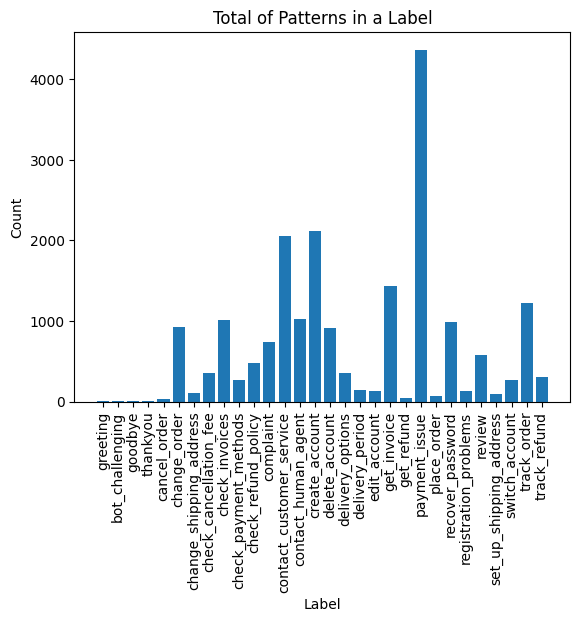

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt


# Count the occurrences of each label using Counter
label_counts = Counter(proccessed_labels)

# Extract the labels and their counts for plotting
labels, counts = zip(*label_counts.items())

# Plot the counts using a bar chart
plt.bar(labels, counts)
plt.ylabel('Count')
plt.xlabel('Label')
plt.title('Total of Patterns in a Label')
plt.xticks(rotation=90)
plt.show()

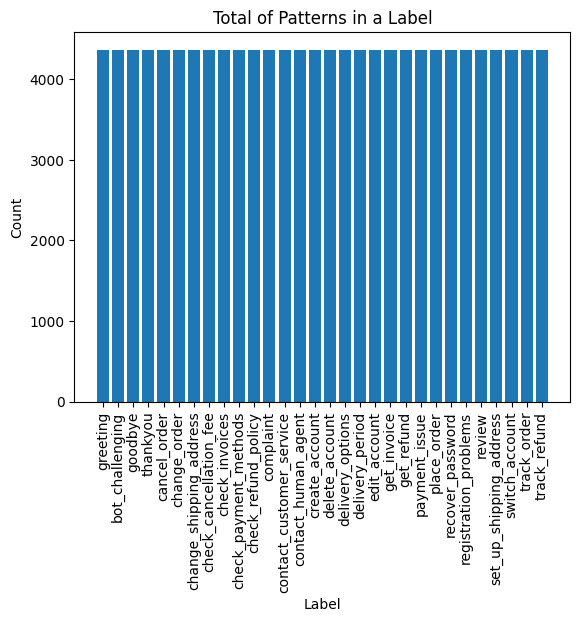

In [ ]:
#Oversamping the data
from imblearn.over_sampling import RandomOverSampler

# Initialize the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the data
Features_resampled, Labels_resampled = oversampler.fit_resample([[feature] for feature in processed_features], proccessed_labels)

# Flatten the resampled features list back into a 1D list
Features_resampled = [feature[0] for feature in Features_resampled]



# Count the occurrences of each label using Counter
label_counts = Counter(Labels_resampled)

# Extract the labels and their counts for plotting
labels, counts = zip(*label_counts.items())

# Plot the counts using a bar chart
plt.bar(labels, counts)
plt.ylabel('Count')
plt.xlabel('Label')
plt.title('Total of Patterns in a Label')
plt.xticks(rotation=90)
plt.show()


#Data Splitting

In [ ]:
from tkinter.constants import X
from sklearn.model_selection import train_test_split

#split the data into train test model 8:2 ratio
X_train, X_test, y_train, y_test = train_test_split(Features_resampled, Labels_resampled, test_size=0.2, random_state=42)

print("Total Train Data: " + str(len(X_train)))
print("Total Test Data: " + str(len(X_test)))


Total Train Data: 104784
Total Test Data: 26196


#Convert the Text data to Numerical Format (Vectorization)

In [ ]:
#Machine cannot understand text data, Vectorization convert it to numerical so machine can understand
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the preprocessed queries (training set)
tfidf_vectorizer.fit(X_train)

# Transform the preprocessed queries into TF-IDF vectors (both training and testing sets)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Print the shape of the TF-IDF features matrix for training set
print("Shape of TF-IDF Features Matrix (Training set):", X_train_tfidf.shape)

# Print the shape of the TF-IDF features matrix for testing set
print("Shape of TF-IDF Features Matrix (Testing set):", X_test_tfidf.shape)


Shape of TF-IDF Features Matrix (Training set): (104784, 1819)
Shape of TF-IDF Features Matrix (Testing set): (26196, 1819)


#Logistic Regression Without Balancing Data

In [ ]:
from tkinter.constants import X
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score

#split the data into train test model 8:2 ratio
X_train2, X_test2, y_train2, y_test2 = train_test_split(processed_features, proccessed_labels, test_size=0.2, random_state=42)

print("Total Train Data: " + str(len(X_train2)))
print("Total Test Data: " + str(len(X_test2)))

Total Train Data: 16194
Total Test Data: 4049


In [ ]:
#Machine cannot understand text data, Vectorization convert it to numerical so machine can understand
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer2 = TfidfVectorizer()

# Fit the vectorizer on the preprocessed queries (training set)
tfidf_vectorizer2.fit(X_train2)

# Transform the preprocessed queries into TF-IDF vectors (both training and testing sets)
X_train_tfidf2 = tfidf_vectorizer2.transform(X_train2)
X_test_tfidf2 = tfidf_vectorizer2.transform(X_test2)

# Print the shape of the TF-IDF features matrix for training set
print("Shape of TF-IDF Features Matrix (Training set):", X_train_tfidf2.shape)

# Print the shape of the TF-IDF features matrix for testing set
print("Shape of TF-IDF Features Matrix (Testing set):", X_test_tfidf2.shape)

Shape of TF-IDF Features Matrix (Training set): (16194, 1603)
Shape of TF-IDF Features Matrix (Testing set): (4049, 1603)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the model with imbalance data
log_reg_imb = LogisticRegression()

# Train the model with imbalance data
log_reg_imb.fit(X_train_tfidf2, y_train2)

LogisticRegression()

In [ ]:
# Predict on train set
y_train_pred2 = log_reg_imb.predict(X_train_tfidf2)

accuracy_train = accuracy_score(y_train2, y_train_pred2)
# Evaluate the train model
print(f"Accuracy Score:{accuracy_train}")
print("Train Set Evaluation:")
print(classification_report(y_train2, y_train_pred2))

Accuracy Score:0.9915400765715697
Train Set Evaluation:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

         bot_challenging       0.00      0.00      0.00         8
            cancel_order       1.00      0.93      0.97        30
            change_order       0.99      1.00      0.99       773
 change_shipping_address       0.99      0.98      0.98        86
  check_cancellation_fee       1.00      1.00      1.00       289
          check_invoices       0.96      0.98      0.97       832
   check_payment_methods       1.00      0.99      1.00       203
     check_refund_policy       1.00      1.00      1.00       381
               complaint       1.00      1.00      1.00       594
contact_customer_service       1.00      1.00      1.00      1631
     contact_human_agent       1.00      1.00      1.00       810
          create_account       0.99      1.00      1.00      1694
          delete_account       1.00      0.99      1.00       704
        delivery_options       1.00      0.99      0.99       293
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

# Predict on test set
y_test_pred2 = log_reg_imb.predict(X_test_tfidf2)

# Evaluate the test model
print()
accuracy_test = accuracy_score(y_train2, y_train_pred2)
print(f"Accuracy Score:{accuracy_test}")
print("Test Set Evaluation:")
print(classification_report(y_test2, y_test_pred2))


Accuracy Score:0.9915400765715697
Test Set Evaluation:
                          precision    recall  f1-score   support

         bot_challenging       0.00      0.00      0.00         2
            cancel_order       1.00      0.83      0.91         6
            change_order       0.98      1.00      0.99       153
 change_shipping_address       0.96      1.00      0.98        24
  check_cancellation_fee       1.00      0.99      0.99        71
          check_invoices       0.95      0.94      0.94       181
   check_payment_methods       1.00      0.99      0.99        67
     check_refund_policy       0.99      0.99      0.99        98
               complaint       1.00      0.99      1.00       152
contact_customer_service       1.00      1.00      1.00       424
     contact_human_agent       1.00      1.00      1.00       216
          create_account       0.98      1.00      0.99       428
          delete_account       1.00      0.98      0.99       209
        delivery_op

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Performance Variable

In [ ]:
import time
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score

#define the variable
Performance = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "prec_time": []
}

#Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
# Initialize the model
log_reg = LogisticRegression(max_iter=200)

# Train the model
log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=200)

In [ ]:
# Predict on train set
y_train_pred = log_reg.predict(X_train_tfidf)

accuracy_train = accuracy_score(y_train, y_train_pred)
# Evaluate the train model
print(f"Accuracy Score:{accuracy_train}")
print("Train Set Evaluation:")
print(classification_report(y_train, y_train_pred))

Accuracy Score:0.9978527256069629
Train Set Evaluation:
                          precision    recall  f1-score   support

         bot_challenging       1.00      1.00      1.00      3519
            cancel_order       1.00      1.00      1.00      3474
            change_order       1.00      1.00      1.00      3456
 change_shipping_address       1.00      1.00      1.00      3482
  check_cancellation_fee       1.00      1.00      1.00      3466
          check_invoices       0.96      0.99      0.97      3457
   check_payment_methods       1.00      1.00      1.00      3467
     check_refund_policy       1.00      1.00      1.00      3541
               complaint       1.00      1.00      1.00      3459
contact_customer_service       1.00      1.00      1.00      3511
     contact_human_agent       1.00      1.00      1.00      3466
          create_account       1.00      0.99      1.00      3470
          delete_account       1.00      1.00      1.00      3466
        delivery_op

In [ ]:
start= time.time()
# Predict on test set
y_test_pred = log_reg.predict(X_test_tfidf)
end=time.time()
# Evaluate the test model
print()
accuracy_test = accuracy_score(y_train, y_train_pred)
print(f"Accuracy Score:{accuracy_test}")
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred))


Accuracy Score:0.9978527256069629
Test Set Evaluation:
                          precision    recall  f1-score   support

         bot_challenging       1.00      1.00      1.00       847
            cancel_order       1.00      1.00      1.00       892
            change_order       1.00      1.00      1.00       910
 change_shipping_address       1.00      1.00      1.00       884
  check_cancellation_fee       1.00      1.00      1.00       900
          check_invoices       0.96      0.99      0.97       909
   check_payment_methods       1.00      1.00      1.00       899
     check_refund_policy       1.00      1.00      1.00       825
               complaint       1.00      1.00      1.00       907
contact_customer_service       1.00      1.00      1.00       855
     contact_human_agent       1.00      1.00      1.00       900
          create_account       1.00      1.00      1.00       896
          delete_account       1.00      1.00      1.00       900
        delivery_op

In [ ]:
Performance["Model"].append("Logistic Regression")
Performance["Accuracy"].append(accuracy_test)
Performance["Precision"].append(precision_score(y_test, y_test_pred, average='weighted'))
Performance["Recall"].append(recall_score(y_test, y_test_pred, average='weighted'))
Performance["F1-Score"].append(f1_score(y_test, y_test_pred, average='weighted'))
Performance["prec_time"].append(end-start)


In [ ]:
print(Performance["Model"][0])
print(Performance["Accuracy"][0])
print(Performance["Precision"][0])
print(Performance["Recall"][0])
print(Performance["F1-Score"][0])
print(Performance["prec_time"][0])

Logistic Regression
0.9978527256069629
0.9979276637515643
0.997900442815697
0.9978993509387252
0.008307933807373047


#Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

# Initialize the model
mlp = MLPClassifier()

# Train the model
mlp.fit(X_train_tfidf, y_train)

MLPClassifier()

In [ ]:
# Predict on train set
y_train_pred = mlp.predict(X_train_tfidf)

accuracy_train = accuracy_score(y_train, y_train_pred)
# Evaluate the train model
print(f"Accuracy Score:{accuracy_train}")
print("Train Set Evaluation:")
print(classification_report(y_train, y_train_pred))

Accuracy Score:0.9983585280195449
Train Set Evaluation:
                          precision    recall  f1-score   support

         bot_challenging       1.00      1.00      1.00      3519
            cancel_order       1.00      1.00      1.00      3474
            change_order       1.00      1.00      1.00      3456
 change_shipping_address       1.00      1.00      1.00      3482
  check_cancellation_fee       1.00      1.00      1.00      3466
          check_invoices       0.96      0.99      0.98      3457
   check_payment_methods       1.00      1.00      1.00      3467
     check_refund_policy       1.00      1.00      1.00      3541
               complaint       1.00      1.00      1.00      3459
contact_customer_service       1.00      1.00      1.00      3511
     contact_human_agent       1.00      1.00      1.00      3466
          create_account       1.00      1.00      1.00      3470
          delete_account       1.00      1.00      1.00      3466
        delivery_op

In [ ]:
start= time.time()
# Predict on test set
y_test_pred = mlp.predict(X_test_tfidf)
end=time.time()
# Evaluate the test model
print()
accuracy_test = accuracy_score(y_train, y_train_pred)
print(f"Accuracy Score:{accuracy_test}")
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred))


Accuracy Score:0.9983585280195449
Test Set Evaluation:
                          precision    recall  f1-score   support

         bot_challenging       1.00      1.00      1.00       847
            cancel_order       1.00      1.00      1.00       892
            change_order       1.00      1.00      1.00       910
 change_shipping_address       1.00      1.00      1.00       884
  check_cancellation_fee       1.00      1.00      1.00       900
          check_invoices       0.96      0.99      0.98       909
   check_payment_methods       1.00      1.00      1.00       899
     check_refund_policy       1.00      1.00      1.00       825
               complaint       1.00      1.00      1.00       907
contact_customer_service       1.00      1.00      1.00       855
     contact_human_agent       1.00      1.00      1.00       900
          create_account       1.00      1.00      1.00       896
          delete_account       1.00      1.00      1.00       900
        delivery_op

In [ ]:
Performance["Model"].append("Neural Network")
Performance["Accuracy"].append(accuracy_test)
Performance["Precision"].append(precision_score(y_test, y_test_pred, average='weighted'))
Performance["Recall"].append(recall_score(y_test, y_test_pred, average='weighted'))
Performance["F1-Score"].append(f1_score(y_test, y_test_pred, average='weighted'))
Performance["prec_time"].append(end-start)

In [ ]:
print(Performance["Model"][1])
print(Performance["Accuracy"][1])
print(Performance["Precision"][1])
print(Performance["Recall"][1])
print(Performance["F1-Score"][1])
print(Performance["prec_time"][1])

Neural Network
0.9983585280195449
0.9984260865340453
0.9983967017865323
0.9983967478464172
0.08265328407287598


#SVM

In [ ]:
from sklearn import svm

#initailize the model
svm_model = svm.SVC(probability=True)

# Train the model
svm_model.fit(X_train_tfidf, y_train)

SVC(probability=True)

In [ ]:
# Predict on train set
y_train_pred = svm_model.predict(X_train_tfidf)

accuracy_train = accuracy_score(y_train, y_train_pred)
# Evaluate the train model
print(f"Accuracy Score:{accuracy_train}")
print("Train Set Evaluation:")
print(classification_report(y_train, y_train_pred))

Accuracy Score:0.9983585280195449
Train Set Evaluation:
                          precision    recall  f1-score   support

         bot_challenging       1.00      1.00      1.00      3519
            cancel_order       1.00      1.00      1.00      3474
            change_order       1.00      1.00      1.00      3456
 change_shipping_address       1.00      1.00      1.00      3482
  check_cancellation_fee       1.00      1.00      1.00      3466
          check_invoices       0.96      0.99      0.98      3457
   check_payment_methods       1.00      1.00      1.00      3467
     check_refund_policy       1.00      1.00      1.00      3541
               complaint       1.00      1.00      1.00      3459
contact_customer_service       1.00      1.00      1.00      3511
     contact_human_agent       1.00      1.00      1.00      3466
          create_account       1.00      1.00      1.00      3470
          delete_account       1.00      1.00      1.00      3466
        delivery_op

In [ ]:
start= time.time()
# Predict on test set
y_test_pred = svm_model.predict(X_test_tfidf)
end=time.time()
# Evaluate the test model
print()
accuracy_test = accuracy_score(y_train, y_train_pred)
print(f"Accuracy Score:{accuracy_test}")
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred))


Accuracy Score:0.9983585280195449
Test Set Evaluation:
                          precision    recall  f1-score   support

         bot_challenging       1.00      1.00      1.00       847
            cancel_order       1.00      1.00      1.00       892
            change_order       1.00      1.00      1.00       910
 change_shipping_address       1.00      1.00      1.00       884
  check_cancellation_fee       1.00      1.00      1.00       900
          check_invoices       0.97      0.98      0.98       909
   check_payment_methods       1.00      1.00      1.00       899
     check_refund_policy       1.00      1.00      1.00       825
               complaint       1.00      1.00      1.00       907
contact_customer_service       1.00      1.00      1.00       855
     contact_human_agent       1.00      1.00      1.00       900
          create_account       1.00      1.00      1.00       896
          delete_account       1.00      1.00      1.00       900
        delivery_op

In [ ]:
Performance["Model"].append("Support Vector Machine (SVM)")
Performance["Accuracy"].append(accuracy_test)
Performance["Precision"].append(precision_score(y_test, y_test_pred, average='weighted'))
Performance["Recall"].append(recall_score(y_test, y_test_pred, average='weighted'))
Performance["F1-Score"].append(f1_score(y_test, y_test_pred, average='weighted'))
Performance["prec_time"].append(end-start)

In [ ]:
print(Performance["Model"][2])
print(Performance["Accuracy"][2])
print(Performance["Precision"][2])
print(Performance["Recall"][2])
print(Performance["F1-Score"][2])
print(Performance["prec_time"][2])

Support Vector Machine (SVM)
0.9983585280195449
0.9982558816293277
0.998244006718583
0.9982430899812744
17.9055814743042


#Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

#initailize the model
mnb = MultinomialNB()

# Train the model
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
# Predict on train set
y_train_pred = mnb.predict(X_train_tfidf)

accuracy_train = accuracy_score(y_train, y_train_pred)
# Evaluate the train model
print(f"Accuracy Score:{accuracy_train}")
print("Train Set Evaluation:")
print(classification_report(y_train, y_train_pred))

Accuracy Score:0.9931573522675218
Train Set Evaluation:
                          precision    recall  f1-score   support

         bot_challenging       1.00      1.00      1.00      3519
            cancel_order       1.00      1.00      1.00      3474
            change_order       1.00      1.00      1.00      3456
 change_shipping_address       1.00      1.00      1.00      3482
  check_cancellation_fee       1.00      1.00      1.00      3466
          check_invoices       0.96      0.98      0.97      3457
   check_payment_methods       1.00      1.00      1.00      3467
     check_refund_policy       1.00      0.99      1.00      3541
               complaint       1.00      1.00      1.00      3459
contact_customer_service       1.00      1.00      1.00      3511
     contact_human_agent       1.00      1.00      1.00      3466
          create_account       1.00      0.97      0.99      3470
          delete_account       0.98      1.00      0.99      3466
        delivery_op

In [ ]:
start= time.time()
# Predict on test set
y_test_pred = mnb.predict(X_test_tfidf)
end=time.time()
# Evaluate the test model
print()
accuracy_test = accuracy_score(y_train, y_train_pred)
print(f"Accuracy Score:{accuracy_test}")
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred))


Accuracy Score:0.9931573522675218
Test Set Evaluation:
                          precision    recall  f1-score   support

         bot_challenging       1.00      1.00      1.00       847
            cancel_order       1.00      1.00      1.00       892
            change_order       1.00      1.00      1.00       910
 change_shipping_address       1.00      1.00      1.00       884
  check_cancellation_fee       1.00      1.00      1.00       900
          check_invoices       0.96      0.97      0.97       909
   check_payment_methods       1.00      1.00      1.00       899
     check_refund_policy       1.00      1.00      1.00       825
               complaint       1.00      1.00      1.00       907
contact_customer_service       1.00      1.00      1.00       855
     contact_human_agent       1.00      1.00      1.00       900
          create_account       1.00      0.98      0.99       896
          delete_account       0.98      1.00      0.99       900
        delivery_op

In [ ]:
Performance["Model"].append("Naive Bayes")
Performance["Accuracy"].append(accuracy_test)
Performance["Precision"].append(precision_score(y_test, y_test_pred, average='weighted'))
Performance["Recall"].append(recall_score(y_test, y_test_pred, average='weighted'))
Performance["F1-Score"].append(f1_score(y_test, y_test_pred, average='weighted'))
Performance["prec_time"].append(end-start)

In [ ]:
print(Performance["Model"][3])
print(Performance["Accuracy"][3])
print(Performance["Precision"][3])
print(Performance["Recall"][3])
print(Performance["F1-Score"][3])
print(Performance["prec_time"][3])

Naive Bayes
0.9931573522675218
0.9933079953455869
0.9931287219422813
0.9930971155247634
0.010245084762573242


#Evaluation

In [ ]:
# Extracting values from the dictionary
models = Performance['Model']
accuracy = Performance['Accuracy']
precision = Performance['Precision']
recall = Performance['Recall']
f1_score = Performance['F1-Score']
time_taken = Performance['prec_time']

Accuracy


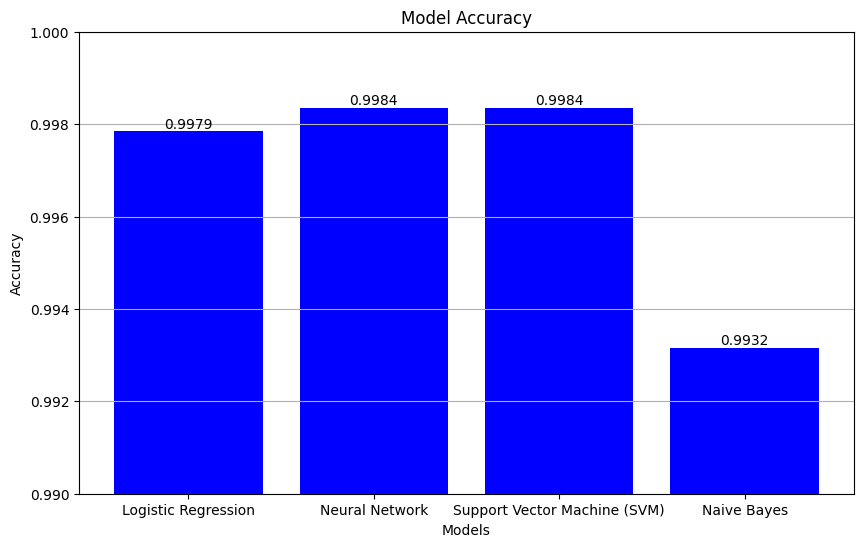

In [ ]:
plt.figure(figsize=(10, 6))

bars = plt.bar(models, accuracy, color='blue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.ylim(0.99, 1.0)  # Zoomed-in y-axis for better sensitivity

# Adding numerical labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.grid(True, axis='y')
plt.show()

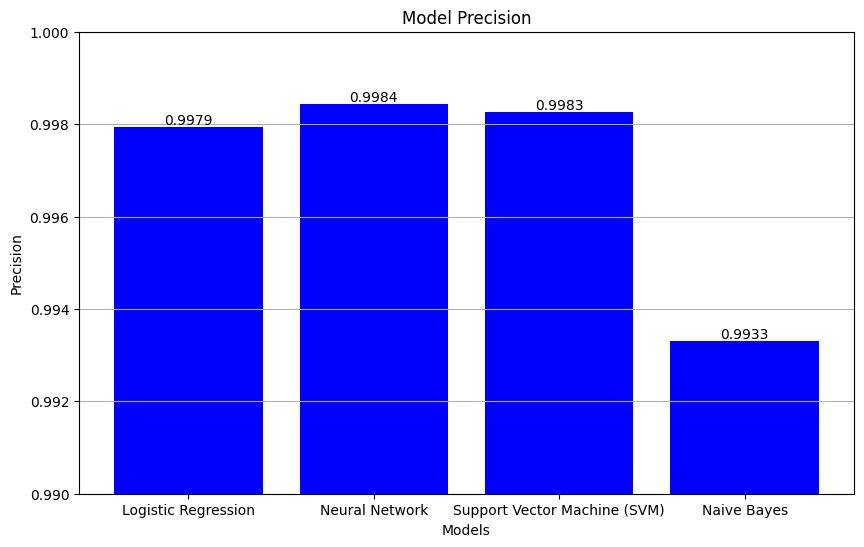

In [ ]:
plt.figure(figsize=(10, 6))

bars = plt.bar(models, precision, color='blue')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Model Precision')
plt.ylim(0.99, 1.0)  # Zoomed-in y-axis for better sensitivity

# Adding numerical labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.grid(True, axis='y')
plt.show()

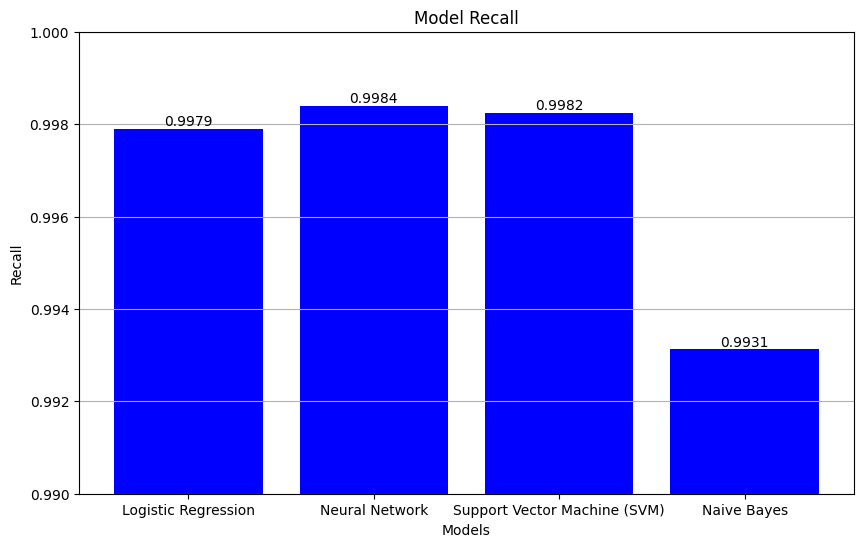

In [ ]:
plt.figure(figsize=(10, 6))

bars = plt.bar(models, recall, color='blue')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Model Recall')
plt.ylim(0.99, 1.0)  # Zoomed-in y-axis for better sensitivity

# Adding numerical labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.grid(True, axis='y')
plt.show()

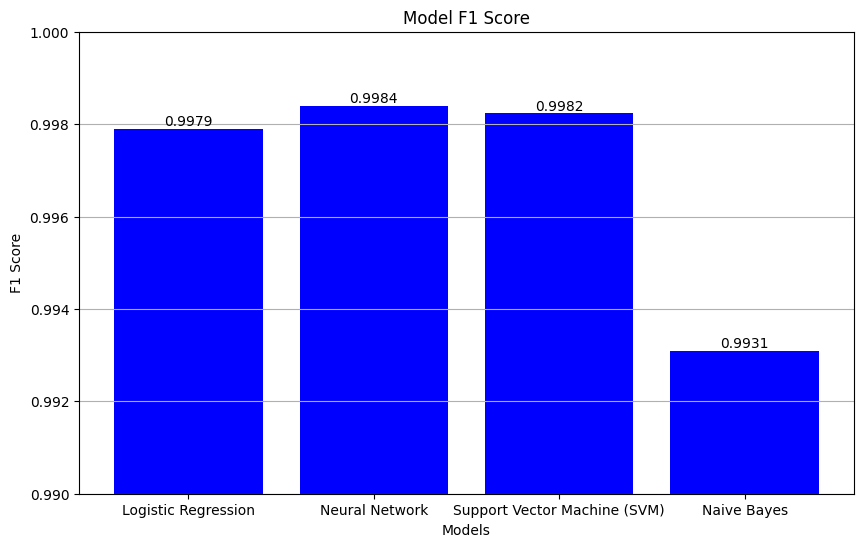

In [ ]:
plt.figure(figsize=(10, 6))

bars = plt.bar(models, f1_score, color='blue')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Model F1 Score')
plt.ylim(0.99, 1.0)  # Zoomed-in y-axis for better sensitivity

# Adding numerical labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.grid(True, axis='y')
plt.show()

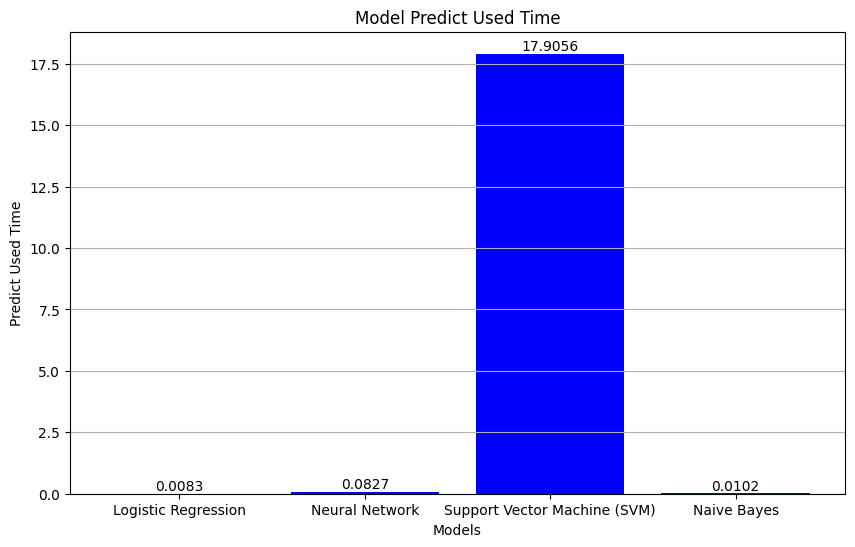

In [ ]:
plt.figure(figsize=(10, 6))

bars = plt.bar(models, time_taken, color='blue')
plt.xlabel('Models')
plt.ylabel('Predict Used Time')
plt.title('Model Predict Used Time')


# Adding numerical labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.grid(True, axis='y')
plt.show()

#K Fold

In [ ]:
#features resample and label resample is predefine in previos section

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

#vectorized the features
X_train = vectorizer.fit_transform(Features_resampled)
Y_train = Labels_resampled
# Print the shape of the TF-IDF features matrix for training set
print("Shape of TF-IDF Features Matrix:", X_train.shape)


Shape of TF-IDF Features Matrix: (130980, 1895)


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize the Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List of classifiers to compare
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Neural Network": MLPClassifier(),
    "SVM": svm.SVC(probability=True),
}

# Define multiple scorers for cross-validation
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

In [ ]:
def evaluate_models(X_train, Y_train, models):
    # Dictionary to store results
    results = {}

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")

        # Compute the average of the 5-fold cross-validation scores for each metric
        scores = {
            'Accuracy': cross_val_score(model, X_train, Y_train, cv=skf, scoring='accuracy').mean(),
            'Precision': cross_val_score(model, X_train, Y_train, cv=skf, scoring='precision_weighted').mean(),
            'Recall': cross_val_score(model, X_train, Y_train, cv=skf, scoring='recall_weighted').mean(),
            'F1-score': cross_val_score(model, X_train, Y_train, cv=skf, scoring='f1_weighted').mean()
        }

        results[model_name] = scores

    return results



In [ ]:
# Call the function to evaluate all models
results = evaluate_models(X_train, Y_train, models)

# Display the results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, score in metrics.items():
        print(f"  {metric_name}: {score:.4f}")
    print("\n")

Evaluating Naive Bayes...
Evaluating Logistic Regression...
Evaluating Neural Network...
Evaluating SVM...
Model: Naive Bayes
  Accuracy: 0.9929
  Precision: 0.9931
  Recall: 0.9929
  F1-score: 0.9929


Model: Logistic Regression
  Accuracy: 0.9976
  Precision: 0.9976
  Recall: 0.9976
  F1-score: 0.9976


Model: Neural Network
  Accuracy: 0.9982
  Precision: 0.9982
  Recall: 0.9982
  F1-score: 0.9981


Model: SVM
  Accuracy: 0.9981
  Precision: 0.9981
  Recall: 0.9981
  F1-score: 0.9981




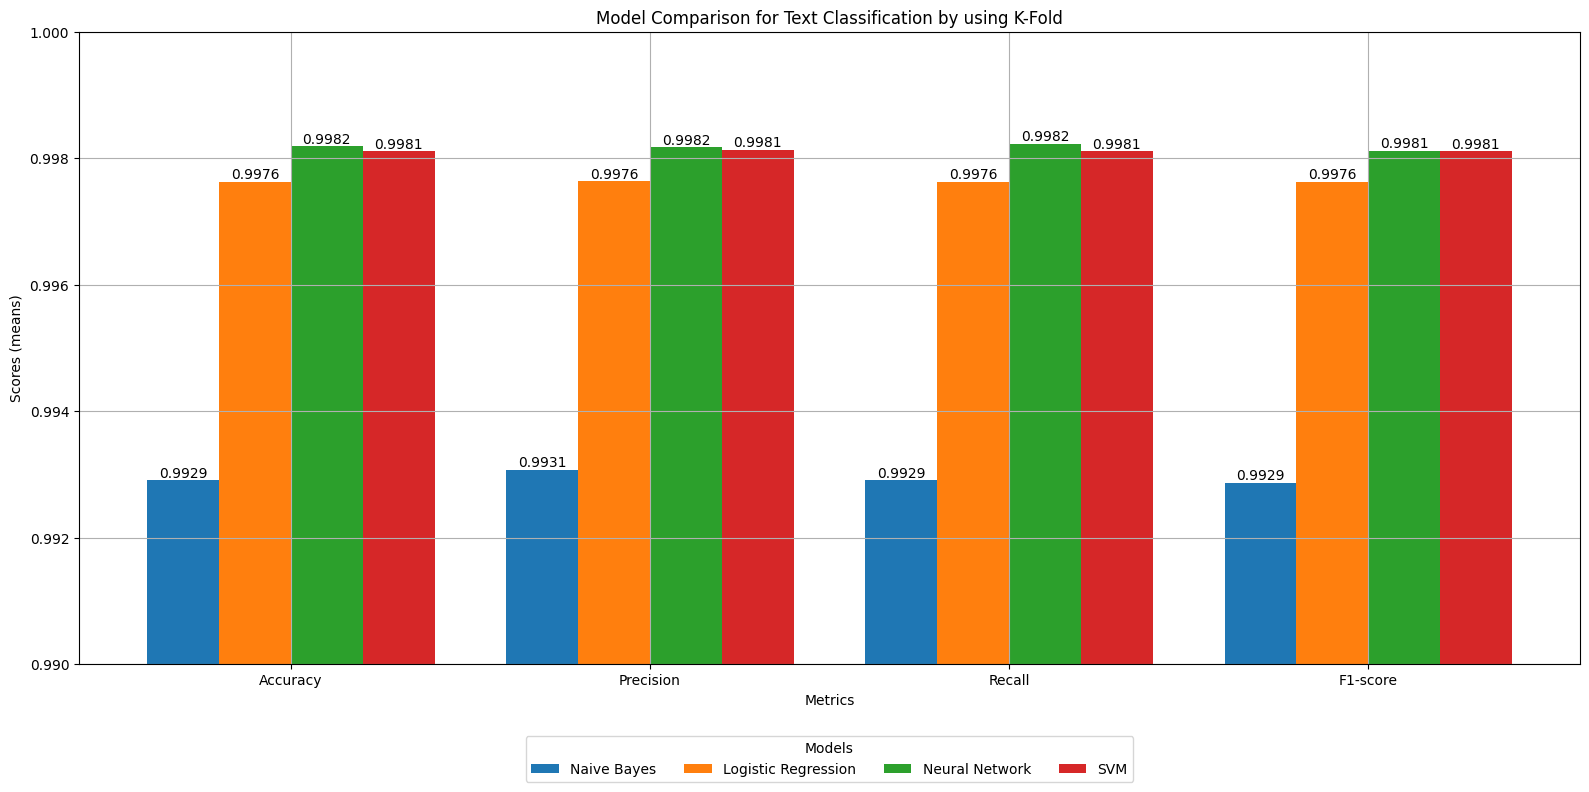

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the grouped bar chart
def plot_grouped_metrics(results):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    models = list(results.keys())

    # Extract the metric scores for each model
    scores = {metric: [results[model][metric] for model in models] for metric in metrics}

    # Number of metrics and models
    n_metrics = len(metrics)
    n_models = len(models)

    # Set the position for each bar on the x-axis
    bar_width = 0.2
    index = np.arange(n_metrics)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(16, 8))

    # Loop over the models and plot each one's bars
    for i, model in enumerate(models):
        bar_positions = index + i * bar_width
        bars = ax.bar(bar_positions, [scores[metric][i] for metric in metrics], bar_width, label=model)

        # Add text annotations (y-values) on each bar
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom', ha='center')

    # Add labels, title, and adjust axis ticks
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores (means)')
    ax.set_title('Model Comparison for Text Classification by using K-Fold')
    ax.set_xticks(index + bar_width * (n_models - 1) / 2)
    ax.set_xticklabels(metrics)
    ax.set_ylim([0.99, 1.0])  # Set y-axis from 0.9 to 1.0 for better visibility

    # Move legend to center of the graph
    ax.legend(title="Models", loc='center', bbox_to_anchor=(0.5, -0.15), ncol=4)

    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_grouped_metrics(results)


#Save Model

In [ ]:
import joblib

# Save the trained model
joblib.dump(log_reg, "log_reg.pkl")
joblib.dump(mnb, "mnb.pkl")
joblib.dump(svm_model, "svm.pkl")
joblib.dump(mlp, "mlp.pkl")
joblib.dump(tfidf_vectorizer, "vectorizer.pkl")

['vectorizer.pkl']